# Intro to LangChain

LangChain is a popular framework that allow users to quickly build apps and pipelines around **L**arge **L**anguage **M**odels. It can be used to for chatbots, **G**enerative **Q**uestion-**A**nwering (GQA), summarization, and much more.

The core idea of the library is that we can _"chain"_ together different components to create more advanced use-cases around LLMs. Chains may consist of multiple components from several modules: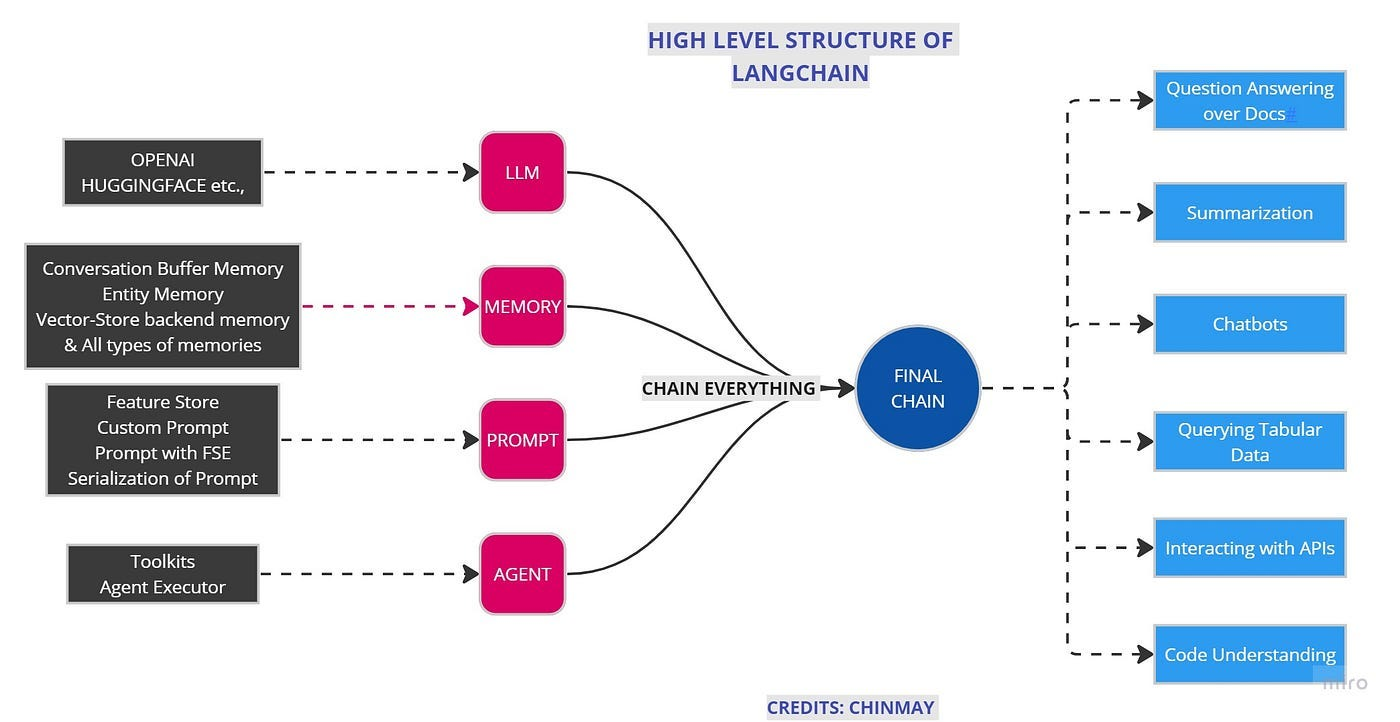

* **Model IO**:
Prompts: Templatize, dynamically select, and manage model inputs
Language models: Make calls to language models through common interfaces
Output parsers: Extract information from model outputs

* **Data connection**: Document loaders: Load documents from many different sources
Document transformers: Split documents, drop redundant documents, and more
Text embedding models: Take unstructured text and turn it into a list of floating point numbers
Vector stores: Store and search over embedded data
Retrievers: Query your data

* **Chains**: Generically as a sequence of calls to components, which can include other chains. The base interface is simple: This idea of composing components together in a chain is simple but powerful. It drastically simplifies and makes more modular the implementation of complex applications, which in turn makes it much easier to debug, maintain, and improve your applications.

* **Memory**: By default, Chains and Agents are stateless, meaning that they treat each incoming query independently (like the underlying LLMs and chat models themselves). In some applications, like chatbots, it is essential to remember previous interactions, both in the short and long-term. The Memory class does exactly that. LangChain provides memory components in two forms.

* **Agents**: Some applications require a flexible chain of calls to LLMs and other tools based on user input. The Agent interface provides the flexibility for such applications. An agent has access to a suite of tools, and determines which ones to use depending on the user input. Agents can use multiple tools, and use the output of one tool as the input to the next. There are two main types of agents: (i) Action agents: at each timestep, decide on the next action using the outputs of all previous actions.(ii) Plan-and-execute agents: decide on the full sequence of actions up front, then execute them all without updating the plan

* **Tools**: the actions an agent can take. What tools you give an agent highly depend on what you want the agent to do
Toolkits: wrappers around collections of tools that can be used together a specific use case. For example, in order for an agent to interact with a SQL database it will likely need one tool to execute queries and another to inspect tables

* **Callbacks**: LangChain provides a callbacks system that allows you to hook into the various stages of your LLM application. This is useful for logging, monitoring, streaming, and other tasks.

* **Ecosystem, Integrations**

# Using LLMs in LangChain

LangChain supports several LLM providers, like Hugging Face and OpenAI. As of now, OpenAI > everything else, but the decision to choose a model depends on a myriad of factors beyond cost - tasks, privacy, ownership, speed, fine-tuning ability and so on.

Let's start our exploration of LangChain by learning how to use a few of these different LLM integrations.

## OpenAI

Start by installing additional prerequisites:

We can also use OpenAI's generative models. The process is similar, we need to
give our API key which can be retrieved by signing up for an account on the
[OpenAI website](https://openai.com/api/) (see top-right of page). We then pass the API key below:

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'OPENAI_KEY_HERE'

Then we decide on which model we'd like to use, there are several options but we will go with `text-davinci-003`:

In [ ]:
from langchain.llms import OpenAI

davinci = OpenAI(model_name='text-davinci-003')

we now pass our OpenAI LLM `davinci`:

In [ ]:
llm_chain = LLMChain(
    prompt=prompt,
    llm=davinci
)

print(llm_chain.run(question))

LLMs and Chat Models are subtly but importantly different. LLMs in LangChain refer to pure text completion models. The APIs they wrap take a string prompt as input and output a string completion. OpenAI's GPT-3 is implemented as an LLM. Chat models are often backed by LLMs but tuned specifically for having conversations. And, crucially, their provider APIs expose a different interface than pure text completion models. Instead of a single string, they take a list of chat messages as input. Usually these messages are labeled with the speaker (usually one of "System", "AI", and "Human"). And they return a ("AI") chat message as output. GPT-4 and Anthropic's Claude are both implemented as Chat Models.

To make it possible to swap LLMs and Chat Models, both implement the Base Language Model interface. This exposes common methods "predict", which takes a string and returns a string, and "predict messages", which takes messages and returns a message. If you are using a specific model it's recommended you use the methods specific to that model class (i.e., "predict" for LLMs and "predict messages" for Chat Models), but if you're creating an application that should work with different types of models the shared interface can be helpful.

In [ ]:
# Illustration of the "stochastic parrot nature" of LLMs -- despite how powerful they are, the ground truth will always be dependent on a particular context based on some latest information or domain knowledge!
from langchain.chat_models import ChatOpenAI

gpt35turbo = ChatOpenAI(model_name='gpt-3.5-turbo-16k')
#gpt4 = ChatOpenAI(model_name='gpt-4')

from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

gpt35turbo([HumanMessage(content=question)])

In [ ]:
# This is a context-aware question. How programmatically provide LLMs with that information?
gpt35turbo([HumanMessage(content="How do I use chains in Langchain?")])

# Data Connection / Document Loaders
That is why we need to augment LLMs with facts by connecting it to document loaders. The community has contributed a ton of data connectors, including structured and non-structured types. Check them out before coding your own data parsers from scratch!

https://python.langchain.com/docs/modules/data_connection/document_loaders

## Example 1: Recursive URL Loader

In [ ]:
from langchain.document_loaders.recursive_url_loader import RecursiveUrlLoader

url = 'https://python.langchain.com/docs/modules/chains/'
loader = RecursiveUrlLoader(url=url)
docs = loader.load()

In [ ]:
len(docs)

In [ ]:
docs[0]

## Vector stores

One of the most common ways to store and search over unstructured data is to embed it and store the resulting embedding vectors, and then at query time to embed the unstructured query and retrieve the embedding vectors that are 'most similar' to the embedded query. A vector store takes care of storing embedded data and performing vector search for you.

This walkthrough uses the FAISS vector database, which makes use of the Facebook AI Similarity Search (FAISS) library.


In [ ]:
!pip install faiss-cpu
!pip install tiktoken

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS

embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(docs, embeddings)

### Load documents as Vectorstore for querying

In [ ]:
# Use
db.similarity_search("How to use chains for document retrieval?")

Using an LLM in isolation is fine for simple applications, but more complex applications require chaining LLMs - either with each other or with other components.

LangChain provides the Chain interface for such "chained" applications. We define a Chain very generically as a sequence of calls to components, which can include other chains. The base interface is simple:

## Example: Retrieval QA Chain

Question-Answering over an index aka vectorstore.

In [ ]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(llm=gpt35turbo, chain_type="stuff", retriever=db.as_retriever(), return_source_documents=True)

In [ ]:
result = qa({"query": "How do I use chains in Langchain?"})

In [ ]:
print(result['result'])

# Getting Started with RAG

While large language models (LLMs) show powerful capabilities that power advanced use cases, they suffer from issues such as factual inconsistency and hallucination. Retrieval-augmented generation (RAG) is a powerful approach to enrich LLM capabilities and improve their reliability. RAG involves combining LLMs with external knowledge by enriching the prompt context with relevant information that helps accomplish a task.

This tutorial shows how to getting started with RAG by leveraging vector store and open-source LLMs. To showcase the power of RAG, this use case will cover building a RAG system that suggests short and easy to read ML paper titles from original ML paper titles. Paper tiles can be too technical for a general audience so using RAG to generate short titles based on previously created short titles can make research paper titles more accessible and used for science communication such as in the form of newsletters or blogs.

Before getting started, let's first install the libraries we will use:

In [ ]:
%%capture
!pip install chromadb tqdm fireworks-ai python-dotenv pandas
!pip install sentence-transformers

Before continuing, you need to obtain a Fireworks API Key to use the Mistral 7B model.

Checkout this quick guide to obtain your Fireworks API Key: https://readme.fireworks.ai/docs

In [ ]:
import fireworks.client
import os
import dotenv
import chromadb
import json
from tqdm.auto import tqdm
import pandas as pd
import random

# you can set envs using Colab secrets
dotenv.load_dotenv()

fireworks.client.api_key = os.getenv("FIREWORKS_API_KEY")

## Getting Started

Let's define a function to get completions from the Fireworks inference platform.

In [ ]:
def get_completion(prompt, model=None, max_tokens=50):

    fw_model_dir = "accounts/fireworks/models/"

    if model is None:
        model = fw_model_dir + "llama-v2-7b"
    else:
        model = fw_model_dir + model

    completion = fireworks.client.Completion.create(
        model=model,
        prompt=prompt,
        max_tokens=max_tokens,
        temperature=0
    )

    return completion.choices[0].text

Let's first try the function with a simple prompt:

In [ ]:
get_completion("Hello, my name is")

' Katie and I am a 20 year old student at the University of Leeds. I am currently studying a BA in English Literature and Creative Writing. I have been working as a tutor for over 3 years now and I'

Now let's test with Mistral-7B-Instruct:

In [ ]:
mistral_llm = "mistral-7b-instruct-4k"

get_completion("Hello, my name is", model=mistral_llm)

' [Your Name]. I am a [Your Profession/Occupation]. I am writing to [Purpose of Writing].\n\nI am writing to [Purpose of Writing] because [Reason for Writing]. I believe that ['

The Mistral 7B Instruct model needs to be instructed using special instruction tokens `[INST] <instruction> [/INST]` to get the right behavior. You can find more instructions on how to prompt Mistral 7B Instruct here: https://docs.mistral.ai/llm/mistral-instruct-v0.1

In [ ]:
mistral_llm = "mistral-7b-instruct-4k"

get_completion("Tell me 2 jokes", model=mistral_llm)

".\n1. Why don't scientists trust atoms? Because they make up everything!\n2. Did you hear about the mathematician who’s afraid of negative numbers? He will stop at nothing to avoid them."

In [ ]:
mistral_llm = "mistral-7b-instruct-4k"

get_completion("[INST]Tell me 2 jokes[/INST]", model=mistral_llm)

" Sure, here are two jokes for you:\n\n1. Why don't scientists trust atoms? Because they make up everything!\n2. Why did the tomato turn red? Because it saw the salad dressing!"

Now let's try with a more complex prompt that involves instructions:

In [ ]:
prompt = """[INST]
Given the following wedding guest data, write a very short 3-sentences thank you letter:

{
  "name": "John Doe",
  "relationship": "Bride's cousin",
  "hometown": "New York, NY",
  "fun_fact": "Climbed Mount Everest in 2020",
  "attending_with": "Sophia Smith",
  "bride_groom_name": "Tom and Mary"
}

Use only the data provided in the JSON object above.

The senders of the letter is the bride and groom, Tom and Mary.
[/INST]"""

get_completion(prompt, model=mistral_llm, max_tokens=150)

" Dear John Doe,\n\nWe, Tom and Mary, would like to extend our heartfelt gratitude for your attendance at our wedding. It was a pleasure to have you there, and we truly appreciate the effort you made to be a part of our special day.\n\nWe were thrilled to learn about your fun fact - climbing Mount Everest is an incredible accomplishment! We hope you had a safe and memorable journey.\n\nThank you again for joining us on this special occasion. We hope to stay in touch and catch up on all the amazing things you've been up to.\n\nWith love,\n\nTom and Mary"

## RAG Use Case: Generating Short Paper Titles

For the RAG use case, we will be using [a dataset](https://github.com/dair-ai/ML-Papers-of-the-Week/tree/main/research) that contains a list of weekly top trending ML papers.

The user will provide an original paper title. We will then take that input and then use the dataset to generate a context of short and catchy papers titles that will help generate catchy title for the original input title.



### Step 1: Load the Dataset

Let's first load the dataset we will use:

In [ ]:
# load dataset from data/ folder to pandas dataframe
# dataset contains column names

ml_papers = pd.read_csv("../data/ml-potw-10232023.csv", header=0)

# remove rows with empty titles or descriptions
ml_papers = ml_papers.dropna(subset=["Title", "Description"])

In [ ]:
ml_papers.head()

,Title,Description,PaperURL,TweetURL,Abstract
0,Llemma,an LLM for mathematics which is based on conti...,https://arxiv.org/abs/2310.10631,https://x.com/zhangir_azerbay/status/171409802...,"We present Llemma, a large language model for ..."
1,LLMs for Software Engineering,a comprehensive survey of LLMs for software en...,https://arxiv.org/abs/2310.03533,https://x.com/omarsar0/status/1713940983199506...,This paper provides a survey of the emerging a...
2,Self-RAG,presents a new retrieval-augmented framework t...,https://arxiv.org/abs/2310.11511,https://x.com/AkariAsai/status/171511027707796...,"Despite their remarkable capabilities, large l..."
3,Retrieval-Augmentation for Long-form Question ...,explores retrieval-augmented language models o...,https://arxiv.org/abs/2310.12150,https://x.com/omarsar0/status/1714986431859282...,We present a study of retrieval-augmented lang...
4,GenBench,presents a framework for characterizing and un...,https://www.nature.com/articles/s42256-023-007...,https://x.com/AIatMeta/status/1715041427283902...,NaN


In [ ]:
# convert dataframe to list of dicts with Title and Description columns only

ml_papers_dict = ml_papers.to_dict(orient="records")

In [ ]:
ml_papers_dict[0]

{'Title': 'Llemma',
 'Description': 'an LLM for mathematics which is based on continued pretraining from Code Llama on the Proof-Pile-2 dataset; the dataset involves scientific paper, web data containing mathematics, and mathematical code; Llemma outperforms open base models and the unreleased Minerva on the MATH benchmark; the model is released, including dataset and code to replicate experiments.',
 'PaperURL': 'https://arxiv.org/abs/2310.10631',
 'TweetURL': 'https://x.com/zhangir_azerbay/status/1714098025956864031?s=20',
 'Abstract': 'We present Llemma, a large language model for mathematics. We continue pretraining Code Llama on the Proof-Pile-2, a mixture of scientific papers, web data containing mathematics, and mathematical code, yielding Llemma. On the MATH benchmark Llemma outperforms all known open base models, as well as the unreleased Minerva model suite on an equi-parameter basis. Moreover, Llemma is capable of tool use and formal theorem proving without any further finet

We will be using SentenceTransformer for generating embeddings that we will store to a chroma document store.

In [ ]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

class MyEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        batch_embeddings = embedding_model.encode(input)
        return batch_embeddings.tolist()

embed_fn = MyEmbeddingFunction()

# Initialize the chromadb directory, and client.
client = chromadb.PersistentClient(path="./chromadb")

# create collection
collection = client.get_or_create_collection(
    name=f"ml-papers-nov-2023"
)

.gitattributes: 100%|██████████| 1.18k/1.18k [00:00<00:00, 194kB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 204kB/s]
README.md: 100%|██████████| 10.6k/10.6k [00:00<00:00, 7.64MB/s]
config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<00:00, 94.0kB/s]
data_config.json: 100%|██████████| 39.3k/39.3k [00:00<00:00, 7.80MB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:03<00:00, 24.3MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 55.4kB/s]
special_tokens_map.json: 100%|██████████| 112/112 [00:00<00:00, 161kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 6.15MB/s]
tokenizer_config.json: 100%|██████████| 350/350 [00:00<00:00, 286kB/s]
train_script.py: 100%|██████████| 13.2k/13.2k [00:00<00:00, 12.2MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 9.15MB/s]
modules.json: 100%|██████████| 349/349 [00:00<00:00, 500kB/s]


We will now generate embeddings for batches:

In [ ]:
# Generate embeddings, and index titles in batches
batch_size = 50

# loop through batches and generated + store embeddings
for i in tqdm(range(0, len(ml_papers_dict), batch_size)):

    i_end = min(i + batch_size, len(ml_papers_dict))
    batch = ml_papers_dict[i : i + batch_size]

    # Replace title with "No Title" if empty string
    batch_titles = [str(paper["Title"]) if str(paper["Title"]) != "" else "No Title" for paper in batch]
    batch_ids = [str(sum(ord(c) + random.randint(1, 10000) for c in paper["Title"])) for paper in batch]
    batch_metadata = [dict(url=paper["PaperURL"],
                           abstract=paper['Abstract'])
                           for paper in batch]

    # generate embeddings
    batch_embeddings = embedding_model.encode(batch_titles)

    # upsert to chromadb
    collection.upsert(
        ids=batch_ids,
        metadatas=batch_metadata,
        documents=batch_titles,
        embeddings=batch_embeddings.tolist(),
    )

100%|██████████| 9/9 [00:01<00:00,  7.62it/s]


Now we can test the retriever:

In [ ]:
collection = client.get_or_create_collection(
    name=f"ml-papers-nov-2023",
    embedding_function=embed_fn
)

retriever_results = collection.query(
    query_texts=["Software Engineering"],
    n_results=2,
)

print(retriever_results["documents"])

[['LLMs for Software Engineering', 'Communicative Agents for Software Development']]


Now let's put together our final prompt:

In [ ]:
# user query
user_query = "S3Eval: A Synthetic, Scalable, Systematic Evaluation Suite for Large Language Models"

# query for user query
results = collection.query(
    query_texts=[user_query],
    n_results=10,
)

# concatenate titles into a single string
short_titles = '\n'.join(results['documents'][0])

prompt_template = f'''[INST]

Your main task is to generate 5 SUGGESTED_TITLES based for the PAPER_TITLE

You should mimic a similar style and length as SHORT_TITLES but PLEASE DO NOT include titles from SHORT_TITLES in the SUGGESTED_TITLES, only generate versions of the PAPER_TILE.

PAPER_TITLE: {user_query}

SHORT_TITLES: {short_titles}

SUGGESTED_TITLES:

[/INST]
'''

responses = get_completion(prompt_template, model=mistral_llm, max_tokens=2000)
suggested_titles = ''.join([str(r) for r in responses])

# Print the suggestions.
print("Model Suggestions:")
print(suggested_titles)
print("\n\n\nPrompt Template:")
print(prompt_template)

Model Suggestions:

1. S3Eval: A Comprehensive Evaluation Suite for Large Language Models
2. Synthetic and Scalable Evaluation for Large Language Models
3. Systematic Evaluation of Large Language Models with S3Eval
4. S3Eval: A Synthetic and Scalable Approach to Language Model Evaluation
5. S3Eval: A Synthetic and Scalable Evaluation Suite for Large Language Models



Prompt Template:
[INST]

Your main task is to generate 5 SUGGESTED_TITLES based for the PAPER_TITLE

You should mimic a similar style and length as SHORT_TITLES but PLEASE DO NOT include titles from SHORT_TITLES in the SUGGESTED_TITLES, only generate versions of the PAPER_TILE.

PAPER_TITLE: S3Eval: A Synthetic, Scalable, Systematic Evaluation Suite for Large Language Models

SHORT_TITLES: Pythia: A Suite for Analyzing Large Language Models Across Training and Scaling
ChemCrow: Augmenting large-language models with chemistry tools
A Survey of Large Language Models
LLaMA: Open and Efficient Foundation Language Models
Spars